# Audio Predictor Evaluation
This notebook helps to see how audio predictor synthesize voice using existing phonemes

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
import math
import textgrid
import random

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, display
from vocos import Vocos

# Local
from utils.misc import dict_to_object, plot_specgram, plot_waveform
from utils.dataset import prepare_textgrid_alignments
from supervoice.audio import spectogram, load_mono_audio
from supervoice.model_audio import AudioPredictor
from supervoice.tokenizer import Tokenizer
from train_config import config

In [2]:
# Vocoder
vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
def do_vocoder(src):
    with torch.no_grad():
        return vocoder.generate(src)

# Tokenizer
tokenizer = Tokenizer(config)
phoneme_duration = config.audio.hop_size / config.audio.sample_rate

# Load index
files = glob("datasets/libritts-aligned/**/*.TextGrid")
files = [f[len("datasets/libritts-aligned/"):-len(".TextGrid")] for f in files]

# First 10
files = files[0:100]

# Load textgrids
tg = [textgrid.TextGrid.fromFile("datasets/libritts-aligned/" + f + ".TextGrid") for f in files]

# Load audio
files = ["datasets/libritts-prepared/" + f + ".wav" for f in files]

Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-vocoder_master


In [3]:
# Data extractor
def extract_tokens(src, audio):
    aligned_phonemes = prepare_textgrid_alignments(src, audio.shape[1], phoneme_duration)
    phonemes = []
    for t in aligned_phonemes:
        for i in range(t[1]):
            phonemes.append(t[0])
    tokens = tokenizer(phonemes)
    return tokens, phonemes

def audio_denormalize(src):
    return (src * config.audio.norm_std) + config.audio.norm_mean

def audio_normalize(src):
    return (src - config.audio.norm_mean) / config.audio.norm_std

def do_spectogram(src):
    return spectogram(src, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.mel_norm, config.audio.mel_scale, config.audio.sample_rate)

### Load Model

In [4]:
device = "cpu"
model = AudioPredictor(config)
model = model.to(device)
checkpoint = torch.load(f'./output/audio_large_begin_end.pt', map_location="cpu")
model.load_state_dict(checkpoint['model'])
model.eval()
print("Predictor at ", checkpoint['step'])

Predictor at  20000


### Load audio with phonemes
This loads sample audio that we would be able to use to compare with synthesized one

Source audio


Re-synth audio


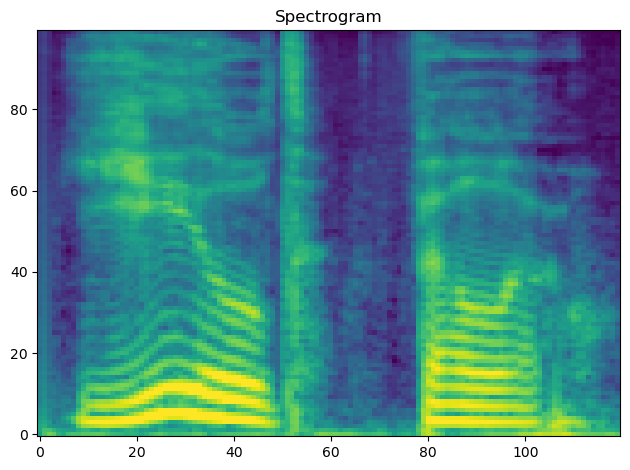

In [5]:
# Load audio
index = 1
waveform = load_mono_audio(files[index], sample_rate = config.audio.sample_rate)
spec = do_spectogram(waveform)
tokens, _ = extract_tokens(tg[index], spec)
tokens = tokens.to(device)
spec = spec[:, :len(tokens)]

# Source audio
print("Source audio")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Re-synth audio")
display(Audio(data=do_vocoder(spec), rate=config.audio.sample_rate))
plot_specgram(spec.cpu())

Conditioning audio


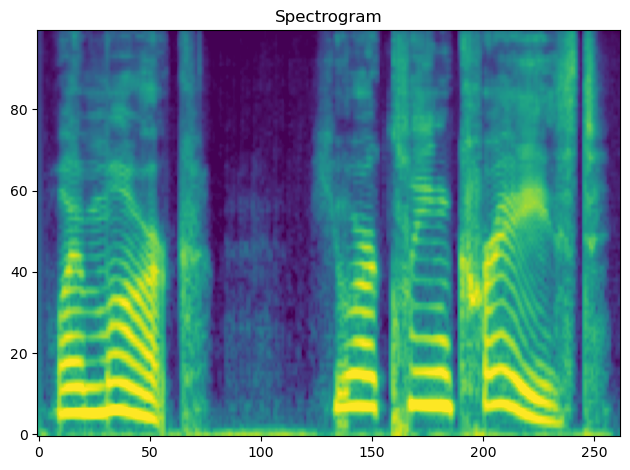

In [6]:
# Load conditioning audio
cond_index = 2
cond_waveform = load_mono_audio(files[cond_index], sample_rate = config.audio.sample_rate)
cond_spec = do_spectogram(cond_waveform)
cond_tokens, _ = extract_tokens(tg[cond_index], cond_spec)
cond_spec = cond_spec[:, :len(cond_tokens)]

# Source audio
print("Conditioning audio")
display(Audio(data=cond_waveform, rate=config.audio.sample_rate))
plot_specgram(cond_spec.cpu())

### Synthesize unconditioned voice

Synthesized without any input


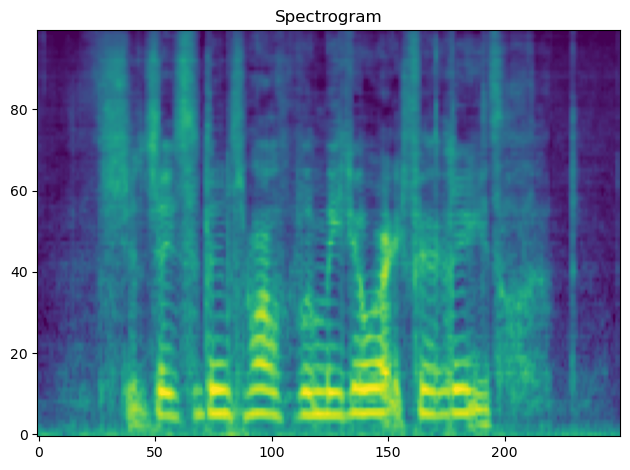

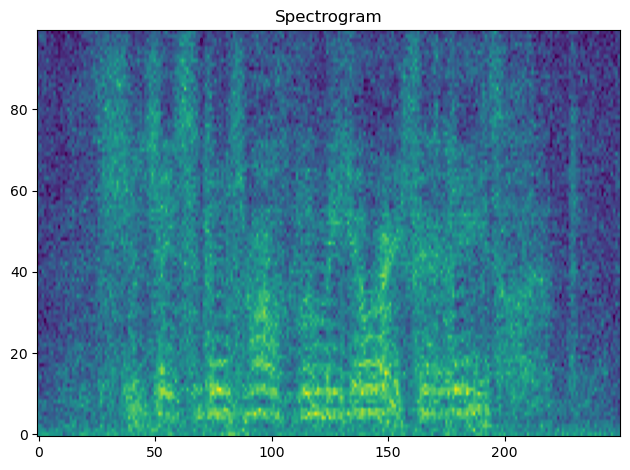

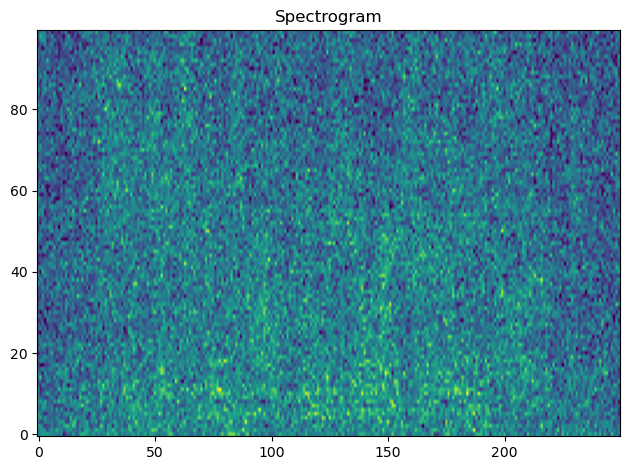

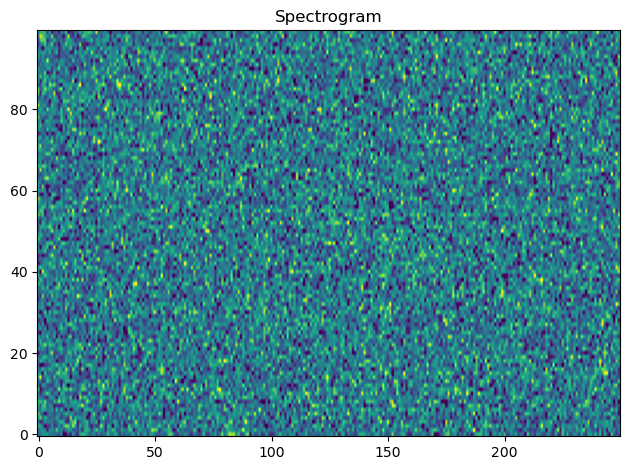

In [7]:
with torch.no_grad():
    sample_tokens = 250
    sample, trajectory = model.sample(
        tokens = torch.zeros((sample_tokens)).long().to(device),  # Empty source audio
        audio = torch.zeros((sample_tokens, config.audio.n_mels)).to(device),  # Empty source audio
        mask = torch.ones((sample_tokens)).bool().to(device), # Mask everything
        steps = 4
    )
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Synthesized without any input")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
for i in reversed(range(len(trajectory))):
    plot_specgram(trajectory[i].transpose(1,0).cpu())    

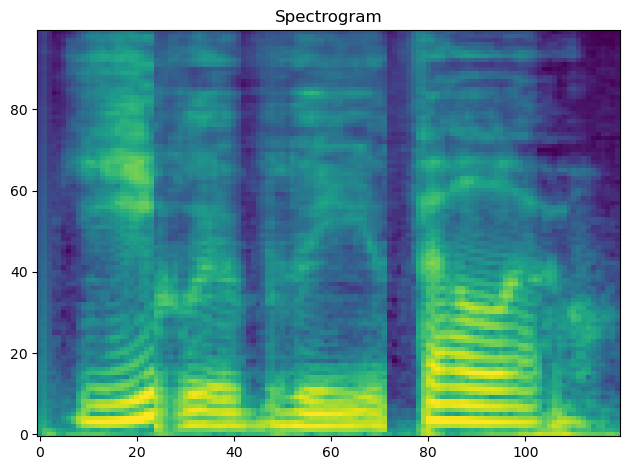

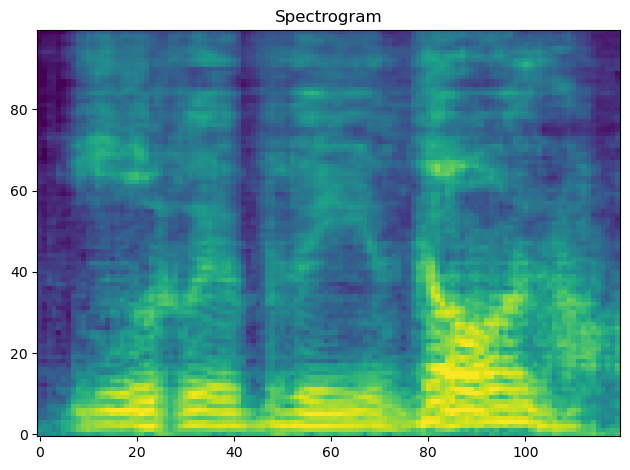

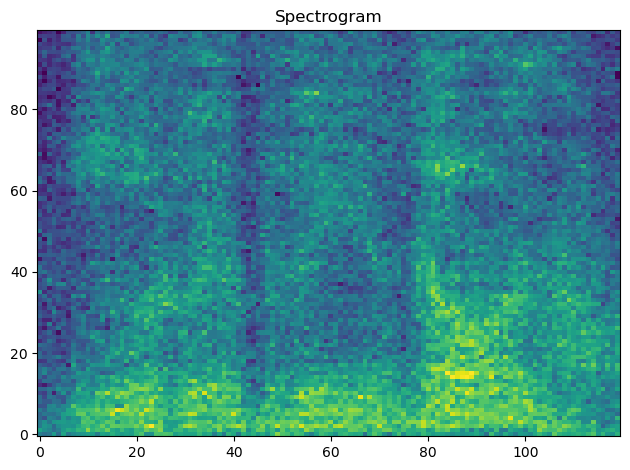

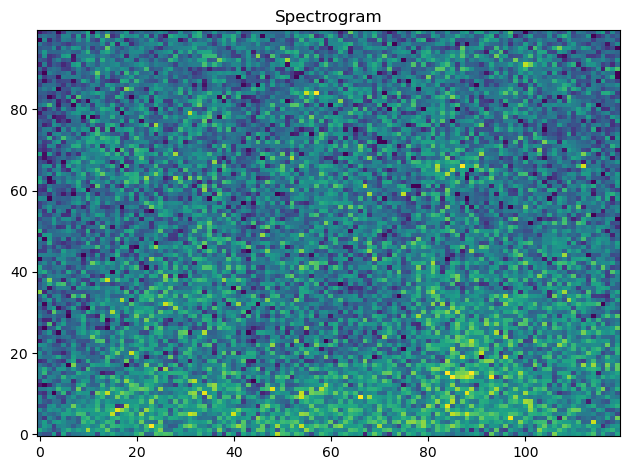

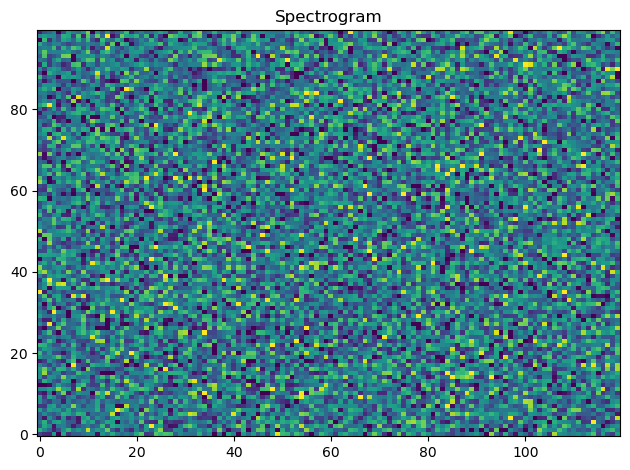

In [8]:
with torch.no_grad():

    # Create a mask
    seq_len = len(tokens)
    mask = torch.zeros((seq_len)).bool().to(device)
    mask[math.floor(seq_len * 0.2): math.floor(seq_len * 0.6)] = True

    # Restore audio
    sample, trajectory = model.sample(
        tokens = torch.zeros((len(tokens))).long().to(device),  # Empty source audio
        audio = audio_normalize(spec.transpose(1,0)),  # Source audio (will be masked by model)
        mask = mask, 
        steps = 4
    )
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).to(device)).detach().cpu()

# Display audio
display(Audio(data=waveform, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
plot_specgram(sample.transpose(1,0).cpu())
for i in reversed(range(len(trajectory))):
    plot_specgram(trajectory[i].transpose(1,0).cpu())    

# Synthesize voice from phonemes
This synthesizes random voice from existing phonemes (taken from another file)

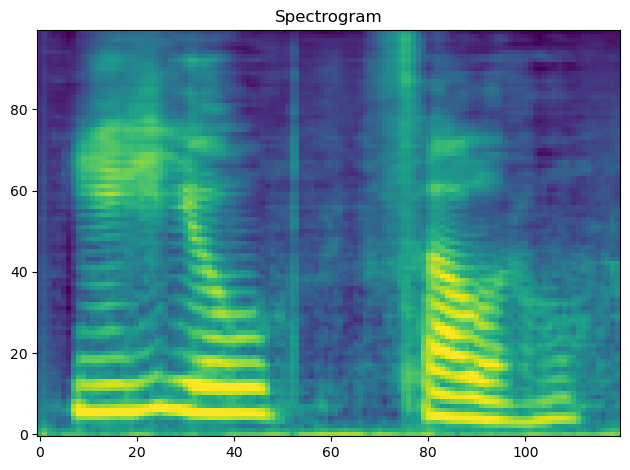

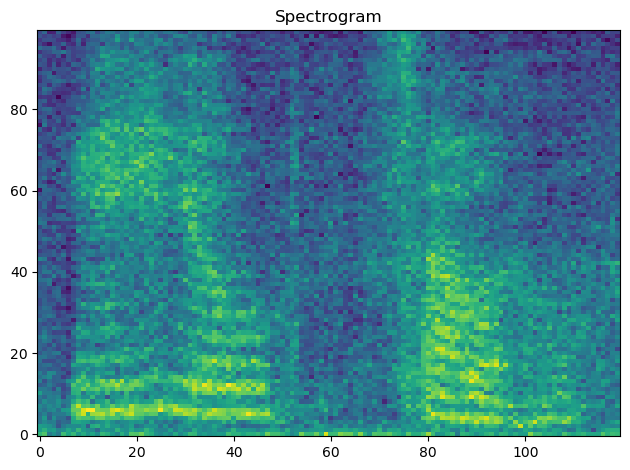

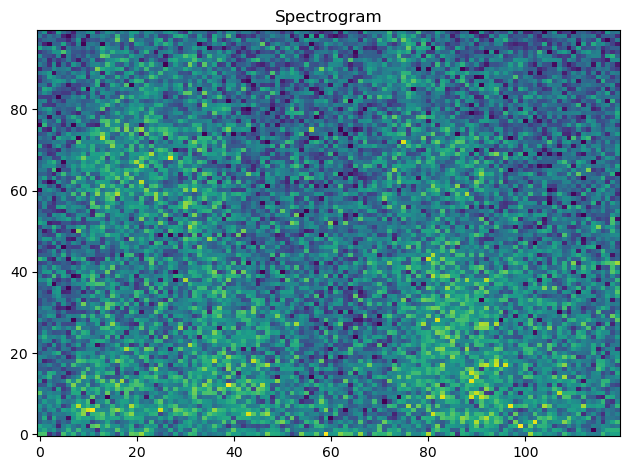

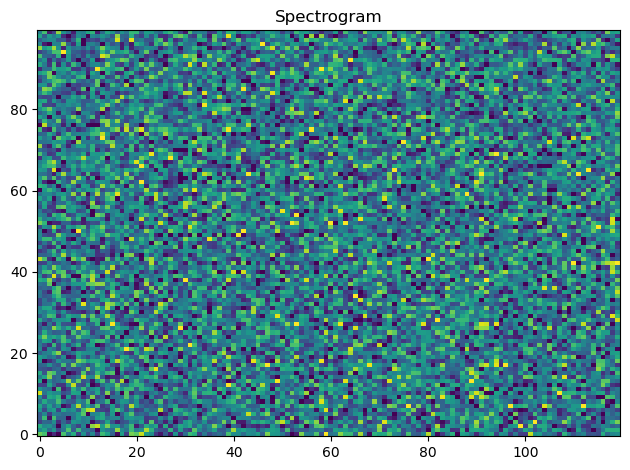

In [9]:
with torch.no_grad():
    sample, trajectory = model.sample(
        tokens = tokens, 
        audio = torch.zeros((len(tokens), config.audio.n_mels)).to(device),  # Empty source audio
        mask = torch.ones((len(tokens))).bool().to(device), # Mask everything
        steps = 4
    )
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
display(Audio(data=waveform, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
for i in reversed(range(len(trajectory))):
    plot_specgram(trajectory[i].transpose(1,0).cpu())    

### Restore segment
Cut part of the audio and re-generate segment

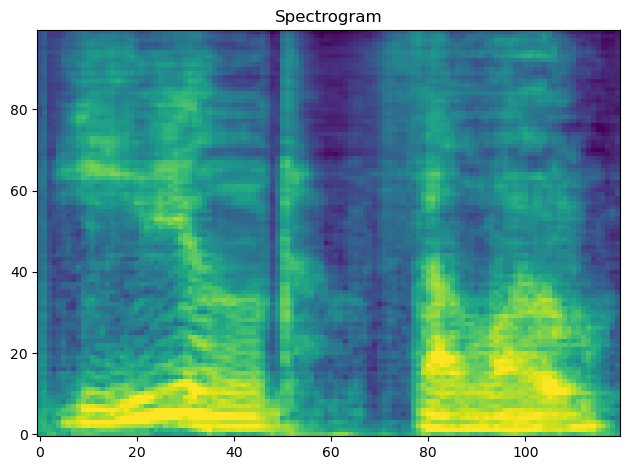

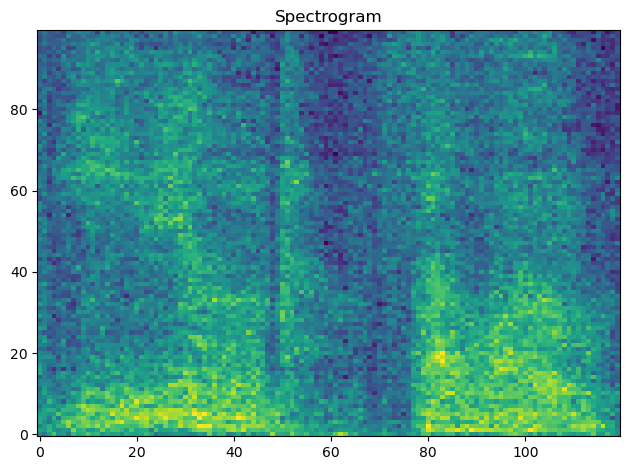

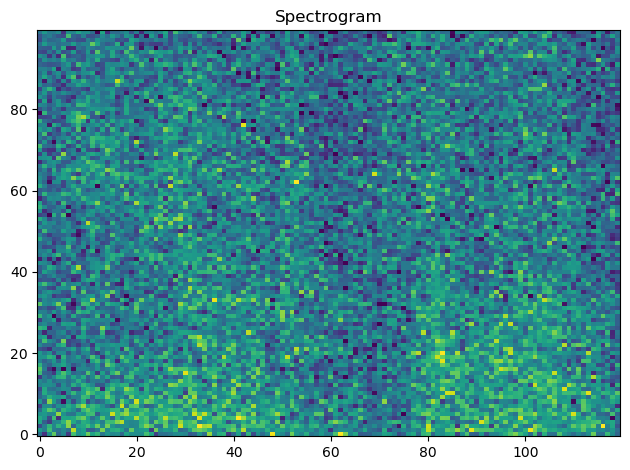

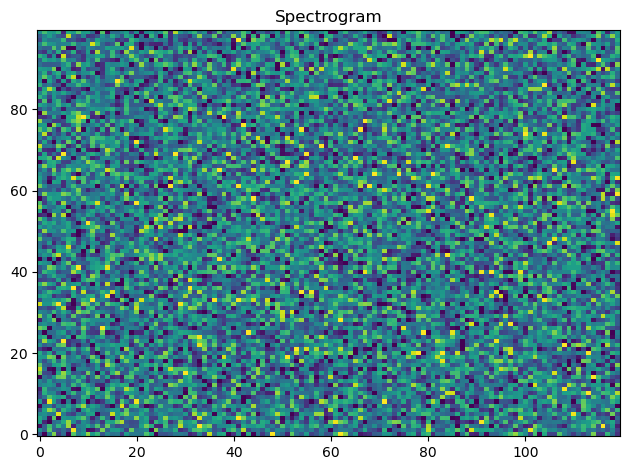

In [10]:
with torch.no_grad():

    # Create a mask
    seq_len = len(tokens)
    mask = torch.zeros((seq_len)).bool().to(device)
    mask[math.floor(seq_len * 0.3): math.floor(seq_len * 0.6)] = True

    # Restore audio
    sample, trajectory = model.sample(
        tokens = tokens, 
        audio = audio_normalize(spec.transpose(1,0)),  # Source audio (will be masked by model)
        mask = mask, 
        steps = 4
    )
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
display(Audio(data=waveform, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
for i in reversed(range(len(trajectory))):
    plot_specgram(trajectory[i].transpose(1,0).cpu())    

### Conditioned TTS

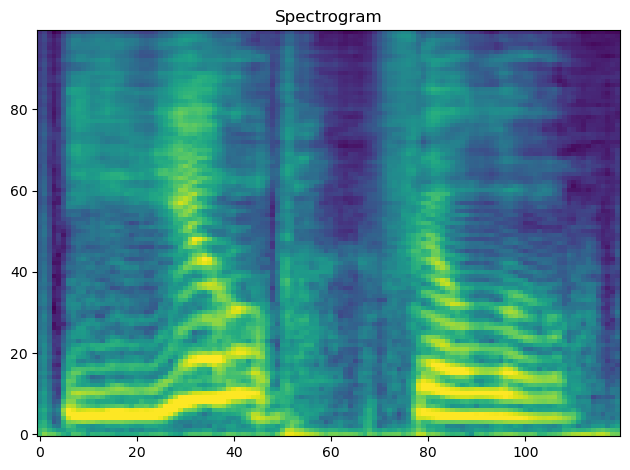

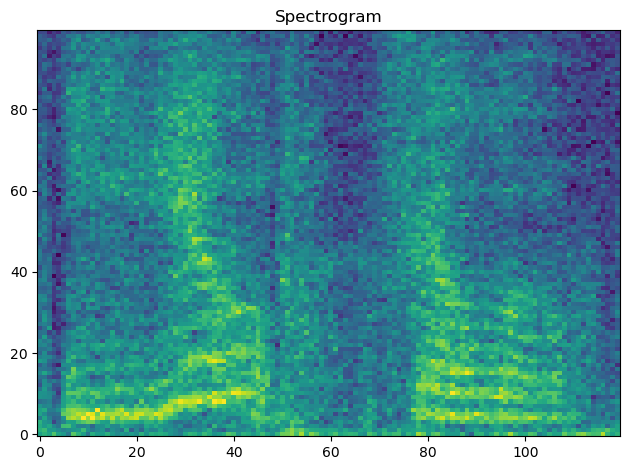

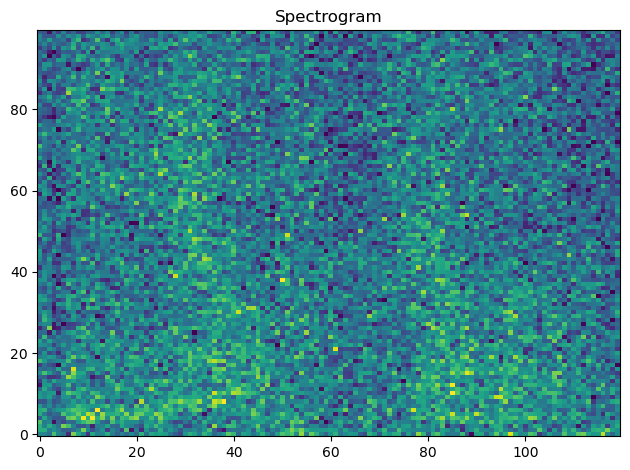

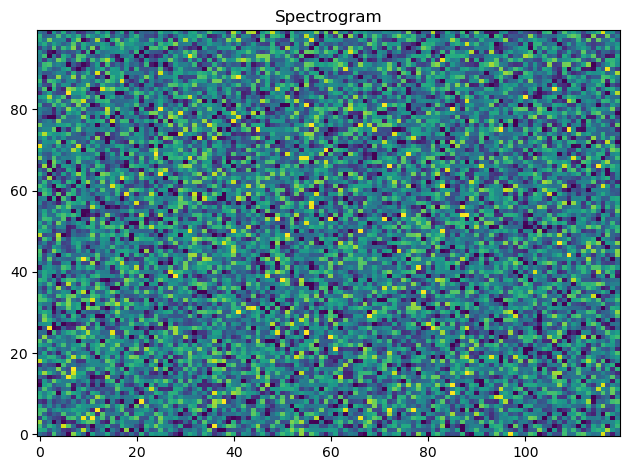

In [11]:
with torch.no_grad():

    # Create a mask
    mask = torch.zeros((len(cond_tokens) + len(tokens))).bool().to(device)
    mask[len(cond_tokens):len(cond_tokens) + len(tokens)] = True

    s = torch.cat([cond_spec.transpose(1,0), torch.zeros(len(tokens), config.audio.n_mels)])
    
    # mask[math.floor(seq_len * 0.3): math.floor(seq_len * 0.6)] = True

    # Restore audio
    sample, trajectory = model.sample(
        tokens = torch.cat([cond_tokens, tokens]),
        audio = audio_normalize(s),  # Source audio (will be masked by model)
        mask = mask, 
        steps = 4
    )
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)
    sample = sample[len(cond_tokens):]
    trajectory = trajectory[:,len(cond_tokens):]

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
display(Audio(data=waveform, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
for i in reversed(range(len(trajectory))):
    plot_specgram(trajectory[i].transpose(1,0).cpu())    

### Variativity

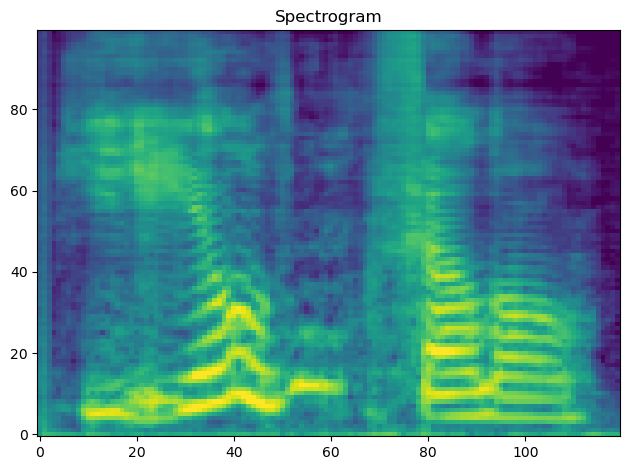

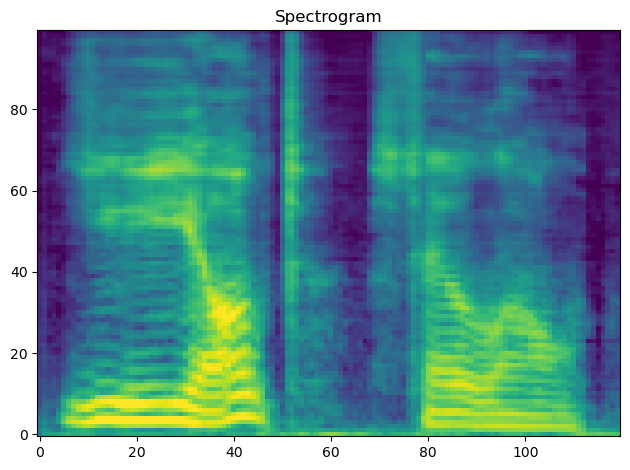

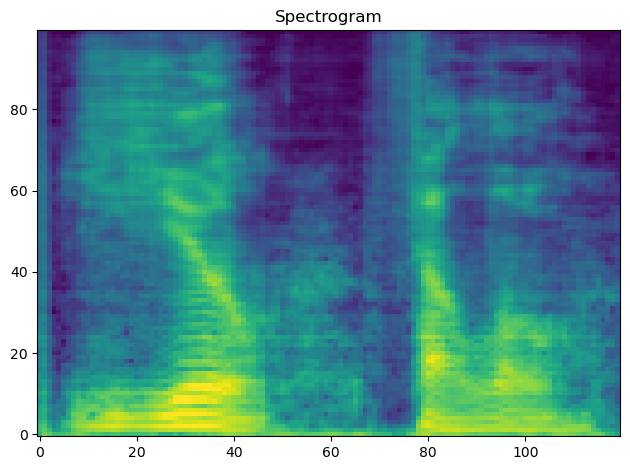

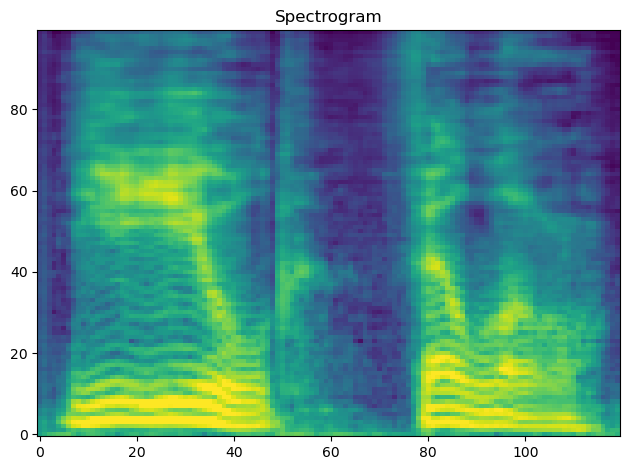

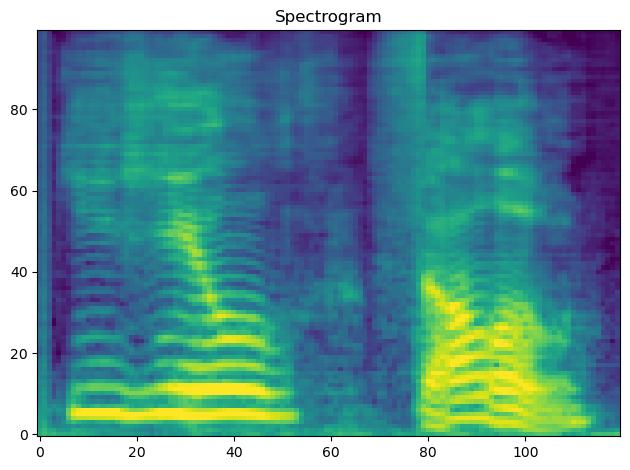

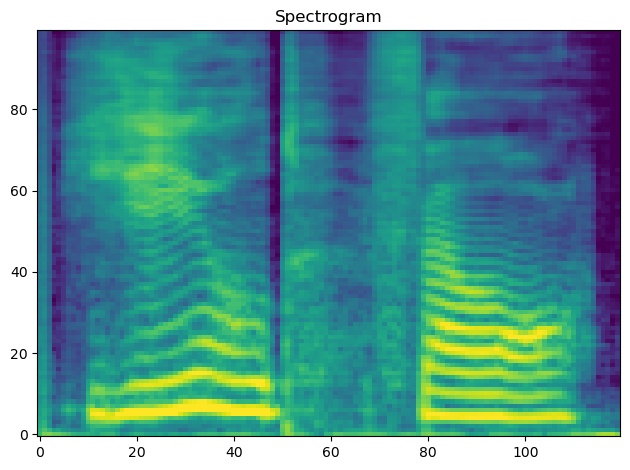

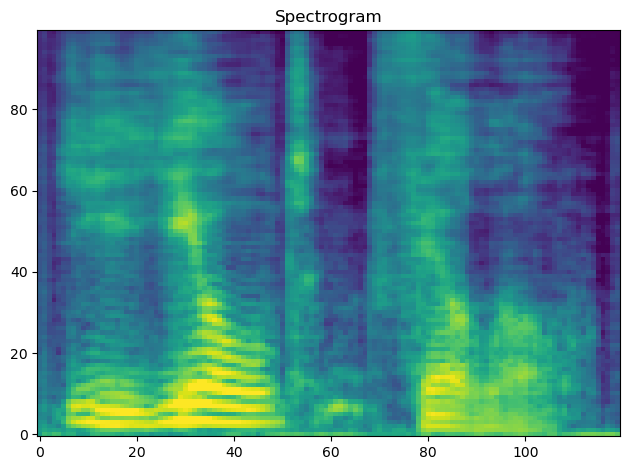

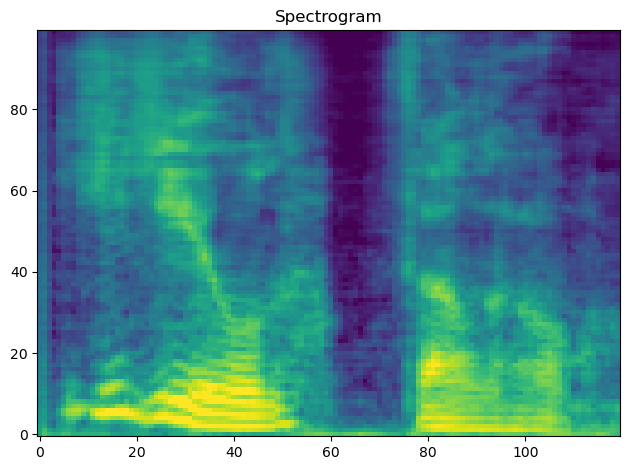

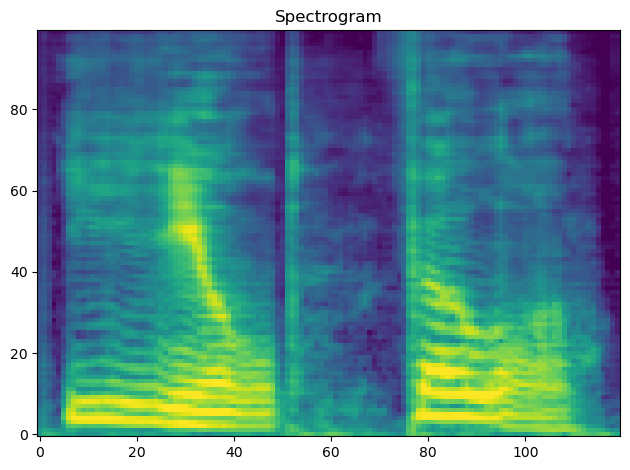

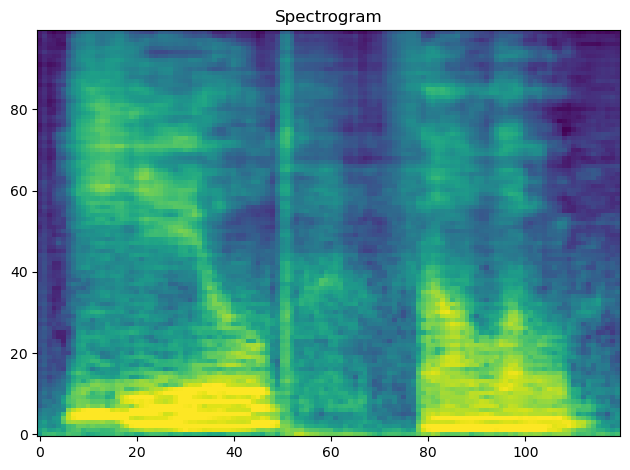

In [12]:
for i in range(10):
    with torch.no_grad():
        sample, trajectory = model.sample(
            tokens = tokens, 
            audio = torch.zeros((len(tokens), config.audio.n_mels)).to(device),  # Empty source audio
            mask = torch.ones((len(tokens))).bool().to(device), # Mask everything
            steps = 4
        )
        sample = audio_denormalize(sample)
        resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)
        display(Audio(data=resynth, rate=config.audio.sample_rate))
        plot_specgram(sample.transpose(1,0).cpu())    

# Resynth
# resynth = generator(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# # Display audio
# display(Audio(data=waveform, rate=config.audio.sample_rate))
# display(Audio(data=resynth, rate=config.audio.sample_rate))

# # Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    